In [2]:
import numpy as np
# from scipy.stats import gaussian_kde as kde
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline

import matplotlib.pyplot as plt
plt.style.use("paper.mplstyle")

from physicsconstants import PhysicsConstants

In [3]:
pc = PhysicsConstants()

GeV = pc.GeV
sec = pc.sec
pbarn = pc.picobarn
au = 1.496e+13 # cm
solar_angle = 6.807e-5 # steradian 

In [4]:
ms            = np.array([100, 250, 500, 1000, 3000, 5000, 10000])
chans         = ["bb", "WW", "tautau"]
ws_chans      = [5, 8, 11]
ws_chan_dict  = {chans[i]:ws_chans[i] for i in range(3)}

si_ann_rate_dict = {500   : 4.5418315143731186e+27,
                    1000  : 1.3457320571730637e+27,
                    3000  : 1.674577361367118e+26,
                    5000  : 6.160055092277992e+25,
                    10000 : 1.5644775205377196e+25
                   } # 1/sec (xs=1 pb)

sd_ann_rate_dict = {500   : 6.697084065971152e+24,
                    1000  : 1.679607455216801e+24,
                    3000  : 1.8680716988310504e+23,
                    5000  : 6.7252930524968645e+22,
                    10000 : 1.681276619465538e+22
                   } # 1/sec (xs=1 pb)

bb_sd_limit      = np.array([3.29e-03, 2.80e-03, 3.06e-03, 2.59e-03, 6.76e-03, 1.58e-02, 5.27e-02]) # picobarns
ww_sd_limit      = np.array([9.52e-05, 5.30e-05, 3.76e-05, 6.80e-05, 5.42e-04, 1.37e-03, 5.96e-03]) # picobarns
tt_sd_limit      = np.array([2.91e-05, 2.82e-05, 1.46e-05, 2.07e-05, 1.21e-04, 3.28e-04, 1.40e-03]) # picobarns
bb_sd_limit_dict = {ms[i]:bb_sd_limit[i] for i in range(len(ms))}
ww_sd_limit_dict = {ms[i]:ww_sd_limit[i] for i in range(len(ms))}
tt_sd_limit_dict = {ms[i]:tt_sd_limit[i] for i in range(len(ms))}
sd_limit_dict    = {"bb":bb_sd_limit_dict, "WW":ww_sd_limit_dict, "tautau":tt_sd_limit_dict}

bb_si_limit = np.array([7.38e-06, 3.50e-06, 2.82e-06, 2.00e-06, 4.65e-06, 1.06e-05, 3.46e-05]) # picobarns
ww_si_limit = np.array([2.13e-07, 6.62e-08, 3.49e-08, 5.28e-08, 3.70e-07, 9.14e-07, 3.88e-06]) # picobarns
tt_si_limit = np.array([6.48e-08, 3.52e-08, 1.35e-08, 1.60e-08, 8.25e-08, 2.19e-07, 9.11e-07]) # picobarns
bb_si_limit_dict = {ms[i]:bb_si_limit[i] for i in range(len(ms))}
ww_si_limit_dict = {ms[i]:ww_si_limit[i] for i in range(len(ms))}
tt_si_limit_dict = {ms[i]:tt_si_limit[i] for i in range(len(ms))}
si_limit_dict    = {"bb":bb_si_limit_dict, "WW":ww_si_limit_dict, "tautau":tt_si_limit_dict}
xs_limit_dict = {}
xs_limit_dict["si"] = si_limit_dict
xs_limit_dict["sd"] = sd_limit_dict

In [5]:
zens  = np.linspace(80, 180, 101)
e_min = 1

In [6]:
def get_min_i(dn_dz):
    nu_ins = []
    for arr in dn_dz[0]:
        nu_ins.append(min(np.where(~(arr>0))[0]))
    nu_bar_ins = []
    for arr in dn_dz[1]:
        nu_bar_ins.append(min(np.where(~(arr>0))[0]))
    print(min(nu_ins), min(nu_bar_ins))
    
    return min(nu_ins), min(nu_bar_ins)

In [14]:
def interp_dn_dz(ch, m):
    
    n_zen = 101
    n_en  = 200
    ee = np.linspace(e_min, m, n_en)
    zens  = np.linspace(80, 180, n_zen)
    
    ws_ch = ws_chan_dict[ch]
    
    # Load data files
    dN_dz  = np.load("/data/user/jlazar/solar_WIMP/data/qr_dn_dz/ch%d_m%d_dn_dz.npy" % (ws_ch, m))
    mnui, mnubari = get_min_i(dN_dz)
    mc     = np.load("/data/user/jlazar/solar_WIMP/data/mcRecarray.npy")
    
    # Get all quantities from dN_dE file arranged
    nu_flux     = dN_dz[0][:,:mnui]
    nu_bar_flux = dN_dz[1][:,:mnubari]
    es_nu       = np.tile(np.linspace(e_min, m, n_en), n_zen)[:mnui]
    es_nu_bar   = np.tile(np.linspace(e_min, m, n_en), n_zen)[:mnubari]
    zs          = np.concatenate([np.full(n_en, zen) for zen in zens])
    
    # Get all mc quantities ready
    nu_i           = np.where(mc["i"]==14)[0]
    nu_bar_i       = np.where(mc["i"]==-14)[0]
    nu_e           = mc["nuE"][nu_i]
    nu_bar_e       = mc["nuE"][nu_bar_i]
    nu_zen         = np.degrees(mc["nuZen"][nu_i])
    nu_bar_zen     = np.degrees(mc["nuZen"][nu_bar_i])
    
    
#     # Prepare points and values arrays
#     nu_points     = np.vstack([es_nu, zs]).T
#     nu_bar_points = np.vstack([es_nu_bar, zs]).T
#     nu_values     = np.log10(np.concatenate(nu_flux))
#     nu_bar_values = np.log10(np.concatenate(nu_bar_flux))

#     # Replace -infinities from log(0) with large neg values
#     nu_values[np.where(np.isinf(nu_values))]         = -500
#     nu_bar_values[np.where(np.isinf(nu_bar_values))] = -500
    
    # Interpolate
    nu_f           = RectBivariateSpline(zens, es_nu,     np.log10(nu_flux))
    nu_bar_f       = RectBivariateSpline(zens, es_nu_bar, np.log10(nu_bar_flux))
    nu_interp      = np.zeros(len(nu_e))
    nu_bar_interp      = np.zeros(len(nu_bar_e))
    for i in range(len(nu_e)):
        nu_interp[i]      = np.power(10, nu_f(nu_zen[i], nu_e[i]))
    for i in range(len(nu_bar_e)):
        nu_bar_interp[i]  = np.power(10, nu_bar_f(nu_bar_zen[i], nu_bar_e[i]))
        
    nu_interp[np.where(nu_e>es_nu[-1])[0]]         = 0
    nu_bar_interp[np.where(nu_bar_e>es_nu_bar[-1])[0]] = 0
    
#     # Save interpolated fluxes
    mc_flux           = np.zeros(len(mc["i"]))
    mc_flux[nu_i]     = nu_interp
    mc_flux[nu_bar_i] = nu_bar_interp
    mc_flux[np.where(np.isnan(mc_flux))] = 0
    np.save("/data/user/jlazar/solar_WIMP/data/mc_dn_dz/ch%d_m%d_mc_dn_dz_bivariate_spline.npy" % (ws_ch, m), mc_flux)
    return mc_flux

In [15]:
for m in [300, 500, 1000, 3000, 5000, 10000]:
    _ = interp_dn_dz("bb", m)

(181, 183)
(175, 173)
(176, 174)
(92, 152)
(95, 135)
(70, 170)


[0.00000000e+00 1.34274148e-05 0.00000000e+00 9.07129546e-02
 4.52492800e-09 0.00000000e+00 1.29563232e-07 0.00000000e+00
 9.60845481e-06 1.49038272e-02 1.15560781e-04 1.07460803e-04
 0.00000000e+00 1.26409575e-06 4.03795667e-04 0.00000000e+00
 4.03240200e-02 0.00000000e+00 5.12523479e-01 1.99079208e-02
 9.31360625e-01 1.02900319e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.84208220e-02 0.00000000e+00 3.43764185e-06
 0.00000000e+00 4.84531775e-08 2.85572538e-03 1.55676224e-09
 2.18432095e-03 5.18370481e-08 6.58122706e-03 4.43261444e-05
 2.17585606e-03 1.20613446e-02 6.97580039e-03 2.41273398e-02
 9.24885435e-02 3.59016354e-01 8.11734972e-06 1.09865198e-01
 0.00000000e+00 2.49188636e-03 2.46754097e-09 0.00000000e+00
 7.15847933e-06 0.00000000e+00]
[ 8049.89692873  1673.74499285 10903.75582265   470.24372207
  3006.3663372   5137.73378848  2355.64897854  3695.18380632
  1695.6076471    701.87596039  1367.34776284  1395.09650121
  8511.8256769   2003.19773747  1207.01664183 10453.9

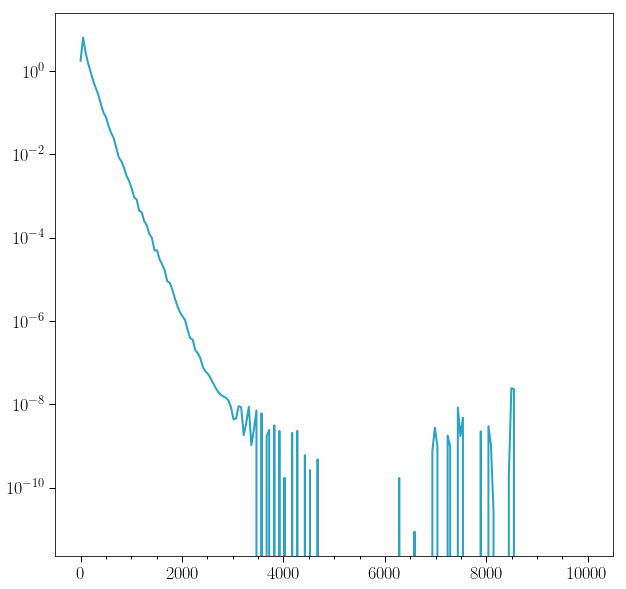

In [11]:
mc     = np.load("/data/user/jlazar/solar_WIMP/data/mcRecarray.npy")
    
nu_i           = np.where(mc["i"]==14)[0]
nu_bar_i       = np.where(mc["i"]==-14)[0]
nu_e           = mc["nuE"][nu_i]
nu_bar_e       = mc["nuE"][nu_bar_i]
nu_zen         = np.degrees(mc["nuZen"][nu_i])
nu_bar_zen     = np.degrees(mc["nuZen"][nu_bar_i])

print(_[nu_i][:50])
print(nu_e[:50])
plt.plot(np.linspace(1,10000,200),np.load("/data/user/jlazar/solar_WIMP/data/qr_dn_dz/ch5_m10000_dn_dz.npy")[0][0])
plt.semilogy()
plt.show()

In [71]:
### Old interpolation method using griddata
# def interp_dn_dz(ch, m):
    
#     ws_ch = ws_chan_dict[ch]
    
#     # Load data files
#     dN_dz  = np.load("/data/user/jlazar/solar_WIMP/data/qr_dn_dz/ch%d_m%d_dn_dz.npy" % (ws_ch, m))
#     mc     = np.load("/data/user/jlazar/solar_WIMP/data/mcRecarray.npy")
    
#     # Get all quantities from dN_dE file arranged
#     nu_flux     = dN_dz[0]
#     nu_bar_flux = dN_dz[1]
#     n_zen       = nu_flux.shape[0]
#     n_en        = nu_flux.shape[1]
#     es          = np.tile(np.linspace(e_min, m, n_en), n_zen)
#     zs          = np.concatenate([np.full(n_en, zen) for zen in zens])
    
#     # Get all mc quantities ready
#     nu_i           = np.where(mc["i"]==14)[0]
#     nu_bar_i       = np.where(mc["i"]==-14)[0]
#     nu_e           = mc["nuE"][nu_i]
#     nu_bar_e       = mc["nuE"][nu_bar_i]
#     nu_zen         = np.degrees(mc["nuZen"][nu_i])
#     nu_bar_zen     = np.degrees(mc["nuZen"][nu_bar_i])
    
    
#     # Prepare points and values arrays
#     points        = np.vstack([es,zs]).T
#     nu_values     = np.log10(np.concatenate(nu_flux))
#     nu_bar_values = np.log10(np.concatenate(nu_bar_flux))

#     # Replace -infinities from log(0) with large neg values
#     nu_values[np.where(np.isinf(nu_values))]         = -500
#     nu_bar_values[np.where(np.isinf(nu_bar_values))] = -500
    
#     # Interpolate
#     nu_gd          = griddata(points, nu_values,     (nu_e, nu_zen),         method="linear")
#     nu_bar_gd      = griddata(points, nu_bar_values, (nu_bar_e, nu_bar_zen), method="linear")
#     nu_interp      = np.power(10, nu_gd)
#     nu_bar_interp  = np.power(10, nu_bar_gd)
        
#     nu_interp[np.where(nu_e>m)[0]]         = 0
#     nu_bar_interp[np.where(nu_bar_e>m)[0]] = 0
    
#     # Save interpolated fluxes
#     mc_flux           = np.zeros(len(mc["i"]))
#     mc_flux[nu_i]     = nu_interp
#     mc_flux[nu_bar_i] = nu_bar_interp
#     mc_flux[np.where(np.isnan(mc_flux))] = 0
#     np.save("/data/user/jlazar/solar_WIMP/data/qr_dn_dz/ch%d_m%d_mc_dn_dz.npy" % (ws_ch, m), mc_flux)
#     return mc_flux

In [48]:
def get_mi

In [49]:
def interp_dn_dz(ch, m):
    
    n_zen = 101
    n_en  = 200
    ee = np.linspace(e_min, m, n_en)
    zens  = np.linspace(80, 180, n_zen)
    
    ws_ch = ws_chan_dict[ch]
    
    # Load data files
    dN_dz  = np.load("/data/user/jlazar/solar_WIMP/data/qr_dn_dz/ch%d_m%d_dn_dz.npy" % (ws_ch, m))
    mc     = np.load("/data/user/jlazar/solar_WIMP/data/mcRecarray.npy")
    
    # Get all quantities from dN_dE file arranged
    nu_flux     = dN_dz[0]
    nu_bar_flux = dN_dz[1]
    es          = np.tile(np.linspace(e_min, m, n_en), n_zen)
    zs          = np.concatenate([np.full(n_en, zen) for zen in zens])
    
    # Get all mc quantities ready
    nu_i           = np.where(mc["i"]==14)[0]
    nu_bar_i       = np.where(mc["i"]==-14)[0]
    nu_e           = mc["nuE"][nu_i]
    nu_bar_e       = mc["nuE"][nu_bar_i]
    nu_zen         = np.degrees(mc["nuZen"][nu_i])
    nu_bar_zen     = np.degrees(mc["nuZen"][nu_bar_i])
    
    
    # Prepare points and values arrays
    points        = np.vstack([es,zs]).T
    nu_values     = np.log10(np.concatenate(nu_flux))
    nu_bar_values = np.log10(np.concatenate(nu_bar_flux))

    # Replace -infinities from log(0) with large neg values
    nu_values[np.where(np.isinf(nu_values))]         = -500
    nu_bar_values[np.where(np.isinf(nu_bar_values))] = -500
    
    # Interpolate
    nu_gd          = griddata(points, nu_values,     (nu_e, nu_zen),         method="linear")
    nu_bar_gd      = griddata(points, nu_bar_values, (nu_bar_e, nu_bar_zen), method="linear")
    nu_interp      = np.power(10, nu_gd)
    nu_bar_interp  = np.power(10, nu_bar_gd)
        
    nu_interp[np.where(nu_e>m)[0]]         = 0
    nu_bar_interp[np.where(nu_bar_e>m)[0]] = 0
    
    # Save interpolated fluxes
    mc_flux           = np.zeros(len(mc["i"]))
    mc_flux[nu_i]     = nu_interp
    mc_flux[nu_bar_i] = nu_bar_interp
    mc_flux[np.where(np.isnan(mc_flux))] = 0
    np.save("/data/user/jlazar/solar_WIMP/data/qr_dn_dz/ch%d_m%d_mc_dn_dz_bivariate_spline.npy" % (ws_ch, m), mc_flux)
    return mc_flux

/Users/jlazar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/Users/jlazar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [71]:
np.power(10, griddata(points, values, (2511.13002521, 21.68800973), method="linear"))

griddata(points, values, (2511.13002521, 21.68800973))

array(nan)

In [1]:
# def interp_flux(ch, m):
    
#     ws_ch = ws_chan_dict[ch]
    
#     # Load data files
#     dN_dE  = np.load("/Users/jlazar/Downloads/ch%d_m%d_flux.npy" % (ws_ch, m))
#     mc     = np.load("/Users/jlazar/Documents/IceCube/data/mcRecarray.npy")
    
#     # Get all quantities from dN_dE file arranged
#     flux        = dN_dE * (1./(4*np.pi*au**2)) * sd_ann_rate_dict[m] * sd_limit_dict[ch][m] / solar_angle
#     nu_flux     = flux[0]
#     nu_bar_flux = flux[1]
#     n_zen       = nu_flux.shape[0]
#     n_en        = nu_flux.shape[1]
#     es          = np.tile(np.linspace(e_min, m, n_en), n_zen)
#     zs          = np.concatenate([np.full(n_en, zen) for zen in zens])
    
#     # Get all mc quantities ready
#     nu_i           = np.where(mc["i"]==14)[0]
#     nu_bar_i       = np.where(mc["i"]==-14)[0]
#     nu_e           = mc["nuE"][nu_i]
#     nu_bar_e       = mc["nuE"][nu_bar_i]
#     nu_zen         = np.degrees(mc["nuZen"][nu_i])
#     nu_bar_zen     = np.degrees(mc["nuZen"][nu_bar_i])
    
    
#     # Prepare points and values arrays
#     points        = np.vstack([es,zs]).T
#     nu_values     = np.log10(np.concatenate(nu_flux))
#     nu_bar_values = np.log10(np.concatenate(nu_bar_flux))

#     # Replace -infinities from log(0) with large neg values
#     nu_values[np.where(np.isinf(nu_values))]         = -500
#     nu_bar_values[np.where(np.isinf(nu_bar_values))] = -500
    
#     # Interpolate
#     nu_gd          = griddata(points, nu_values,     (nu_e, nu_zen),         method="linear")
#     nu_bar_gd      = griddata(points, nu_bar_values, (nu_bar_e, nu_bar_zen), method="linear")
#     nu_interp      = np.power(10, nu_gd)
#     nu_bar_interp  = np.power(10, nu_bar_gd)
        
#     nu_interp[np.where(nu_e>m)[0]]         = 0
#     nu_bar_interp[np.where(nu_bar_e>m)[0]] = 0
    
#     # Save interpolated fluxes
#     mc_flux           = np.zeros(len(mc["i"]))
#     mc_flux[nu_i]     = nu_interp
#     mc_flux[nu_bar_i] = nu_bar_interp
#     mc_flux[np.where(np.isnan(mc_flux))] = 0
#     np.save("/Users/jlazar/Documents/IceCube/data/ch%d_m%d_mc_flux.npy" % (ws_ch, m), mc_flux)
#     return mc_flux

In [2]:
# plz = interp_flux("tautau", 3000)

In [3]:
# for m in ms[2:]:
#     for ch in chans:
#         interp_flux(ch, m)

In [4]:
# plt.plot(np.linspace(0,1,200), np.load("/Users/jlazar/Documents/IceCube/data/ch8_m1000_flux.npy")[0][0])
# plt.semilogy()
# plt.xlabel(r"$x=\frac{E_{\nu}}{m_{\chi}}$")
# plt.ylabel(r"$\frac{dN_{\oplus}}{dx}$")
# plt.grid(which="both")
# plt.title(r"$\chi\chi\rightarrow W^{+}W^{-}, m_{\chi}=1000$ GeV")
# plt.show()

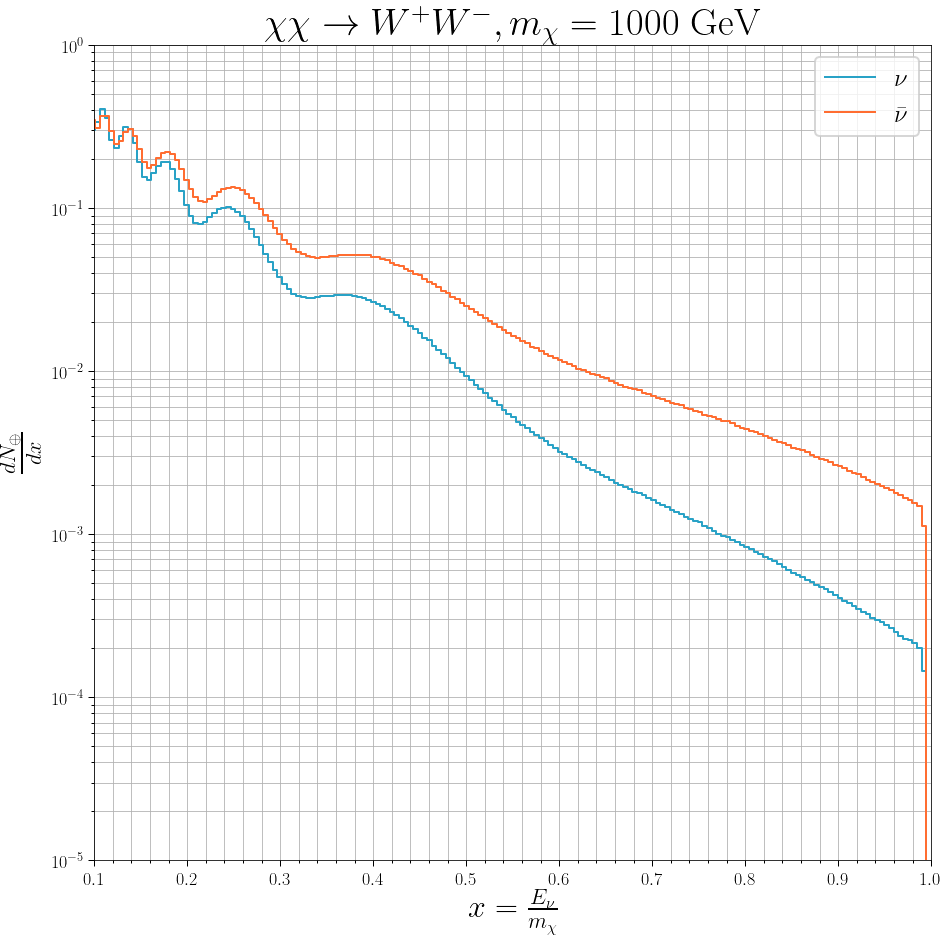

In [37]:
f = np.load("ch8_m1000_test.npy")*1000
plt.step(np.linspace(0.001,1,200), f[0],label=r"$\nu$")
plt.step(np.linspace(0.001,1,200), f[1],label=r"$\bar{\nu}$")
plt.semilogy()
plt.xlabel(r"$x=\frac{E_{\nu}}{m_{\chi}}$")
plt.ylabel(r"$\frac{dN_{\oplus}}{dx}$")
plt.grid(which="both")
plt.legend()
plt.ylim(1e-5,1)
plt.xlim(0.1,1)
plt.title(r"$\chi\chi\rightarrow W^{+}W^{-}, m_{\chi}=1000$ GeV")
plt.show()

## bb check

In [92]:
end_i = 70
nu_dn_dz = np.load("/data/user/jlazar/solar_WIMP/data/qr_dn_dz/ch5_m10000_dn_dz.npy")[0][:,:end_i]
nu_bar_dn_dz = np.load("/data/user/jlazar/solar_WIMP/data/qr_dn_dz/ch5_m10000_dn_dz.npy")[1][:,:end_i]


zens = np.linspace(80, 180, nu_bar_dn_dz.shape[0])
ee  = np.linspace(1, 10000, 200)[:end_i]
f   = RectBivariateSpline(zens, ee, np.log10(nu_dn_dz))

def get_nu_dn_dz(e, z):
    return np.power(10, f(z, e))


In [83]:
for arr in np.load("/data/user/jlazar/solar_WIMP/data/qr_dn_dz/ch5_m10000_dn_dz.npy")[1]:
    print(min(np.where(~(arr>0))[0]))
print nu_dn_dz[0]

170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
170
[1.75737648e+00 6.38339302e+00 2.74791436e+00 1.50099677e+00
 9.21543326e-01 5.72239977e-01 3.83029509e-01 2.66113854e-01
 1.57877425e-01 9.93461496e-02 7.75721588e-02 4.70220611e-02
 3.26080223e-02 2.44756681e-02 1.44784521e-02 8.39106522e-03
 6.85268878e-03 4.82457436e-03 3.08694997e-03 2.30551126e-03
 1.56611659e-03 9.40662884e-04 8.17895887e-04 4.46648153e-04
 4.04273094e-04 2.46332672e-04 1.97650419e-04 1.21191335e-04
 9.87755573e-05 4.91115865e-05 4.96403835e-05 2.99596900e-05
 2.28251792e-05 1.64909639e-05 8.98336220e-06 8.17702889e-06
 5.68843895e-06 3.45876870e-06 2.27086308e-06 1

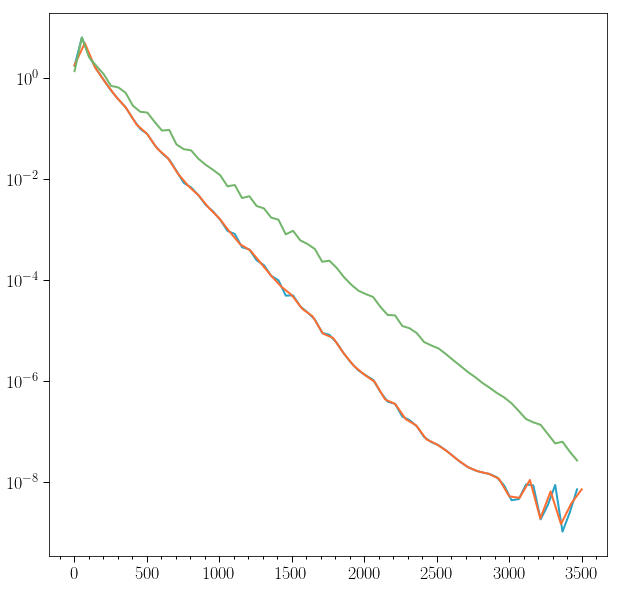

In [61]:
plt.plot(ee,nu_dn_dz[0])
plt.plot(np.linspace(0,3500,50), get_nu_dn_dz(np.linspace(0,3500,50), 90.5)[0])
plt.plot(ee,nu_bar_dn_dz[0])
plt.semilogy()
plt.show()

In [62]:
# points = np.vstack([es,zs]).T
# values = np.log10(np.concatenate(nu_flux))
# values[np.where(np.isinf(values))] = -500

In [63]:
# test = griddata(points[:400], values[:400], (es, 80.), method="cubic")

In [64]:
# flux = np.load(" /ch8_m1000_flux.npy")
# nu_flux     = flux[0]
# nu_bar_flux = flux[1]
# n_zen       = nu_flux.shape[0]
# n_en        = nu_flux.shape[1]
# es          = np.tile(np.linspace(e_min, 1000, n_en), n_zen)
# zs          = np.concatenate([np.full(n_en, zen) for zen in zens])

In [66]:
# plt.plot(points.T[0][200:400], np.power(10, values[200:400]))
# plt.plot(points.T[0][200:400], np.power(10, test[200:400]))
# plt.semilogy()
# plt.show()

In [67]:
# flux = np.load("/Users/jlazar/Documents/IceCube/data/ch11_m3000_flux.npy")
# nu_flux     = flux[0]
# nu_bar_flux = flux[1]
# n_zen       = nu_flux.shape[0]
# n_en        = nu_flux.shape[1]
# es          = np.tile(np.linspace(e_min, 3000, n_en), n_zen)
# zs          = np.concatenate([np.full(n_en, zen) for zen in zens])

In [68]:
# points = np.vstack([es,zs]).T
# values = np.log10(np.concatenate(nu_flux))
# values[np.where(np.isinf(values))] = -500